Cylinder Flow (Steady) DEMO code

This notebook demonstrates solving steady-state Cavity Flow with the same setup as https://www.comsol.com/blogs/how-to-solve-a-classic-cfd-benchmark-the-lid-driven-cavity-problem.

In [1]:
import deepflow as df
print("Deepflow is runned on:", df.device) # to change to cpu use df.device = 'cpu'
df.manual_seed(69) # for reproducibility

Deepflow is runned on: cuda


## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [2]:
rectangle = df.geometry.rectangle([0, 1], [0, 1])

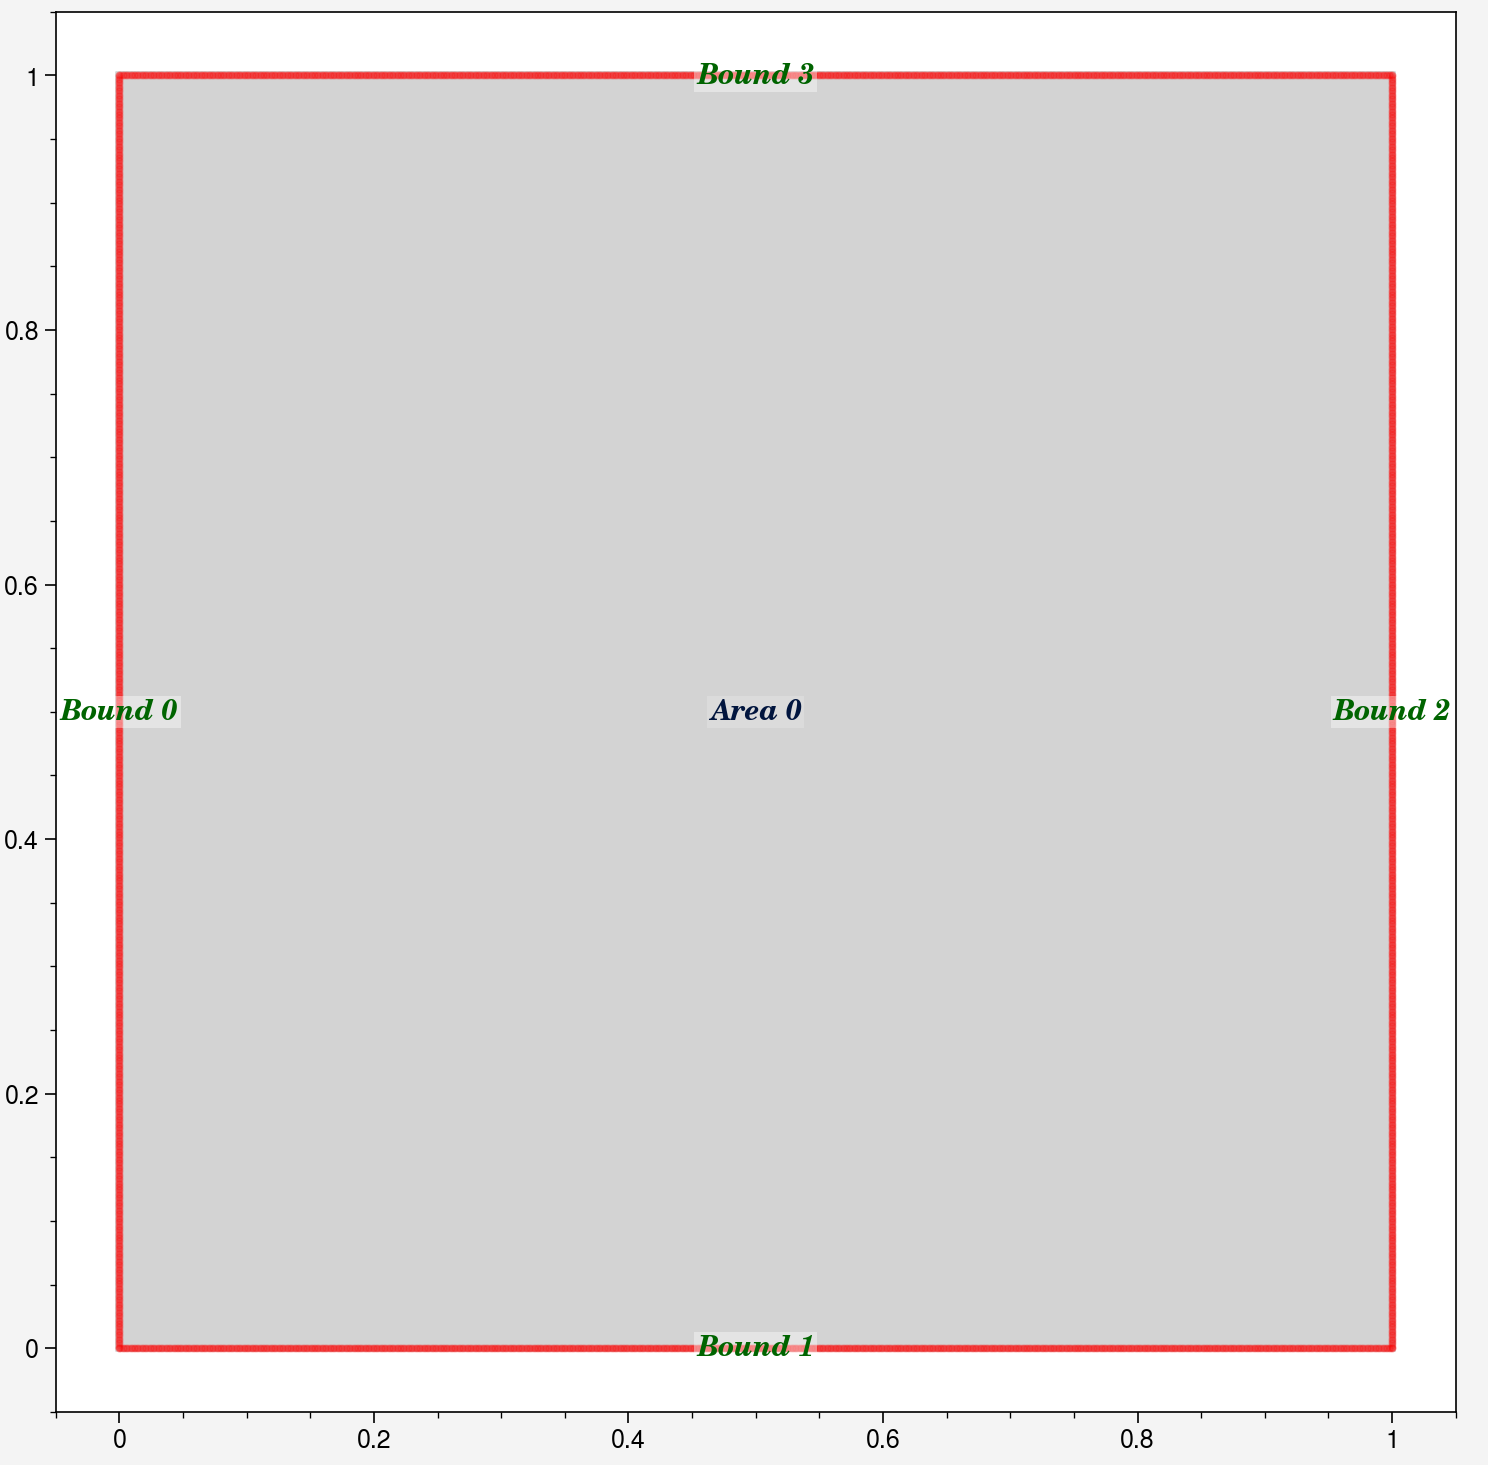

In [3]:
domain = df.domain(rectangle)
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

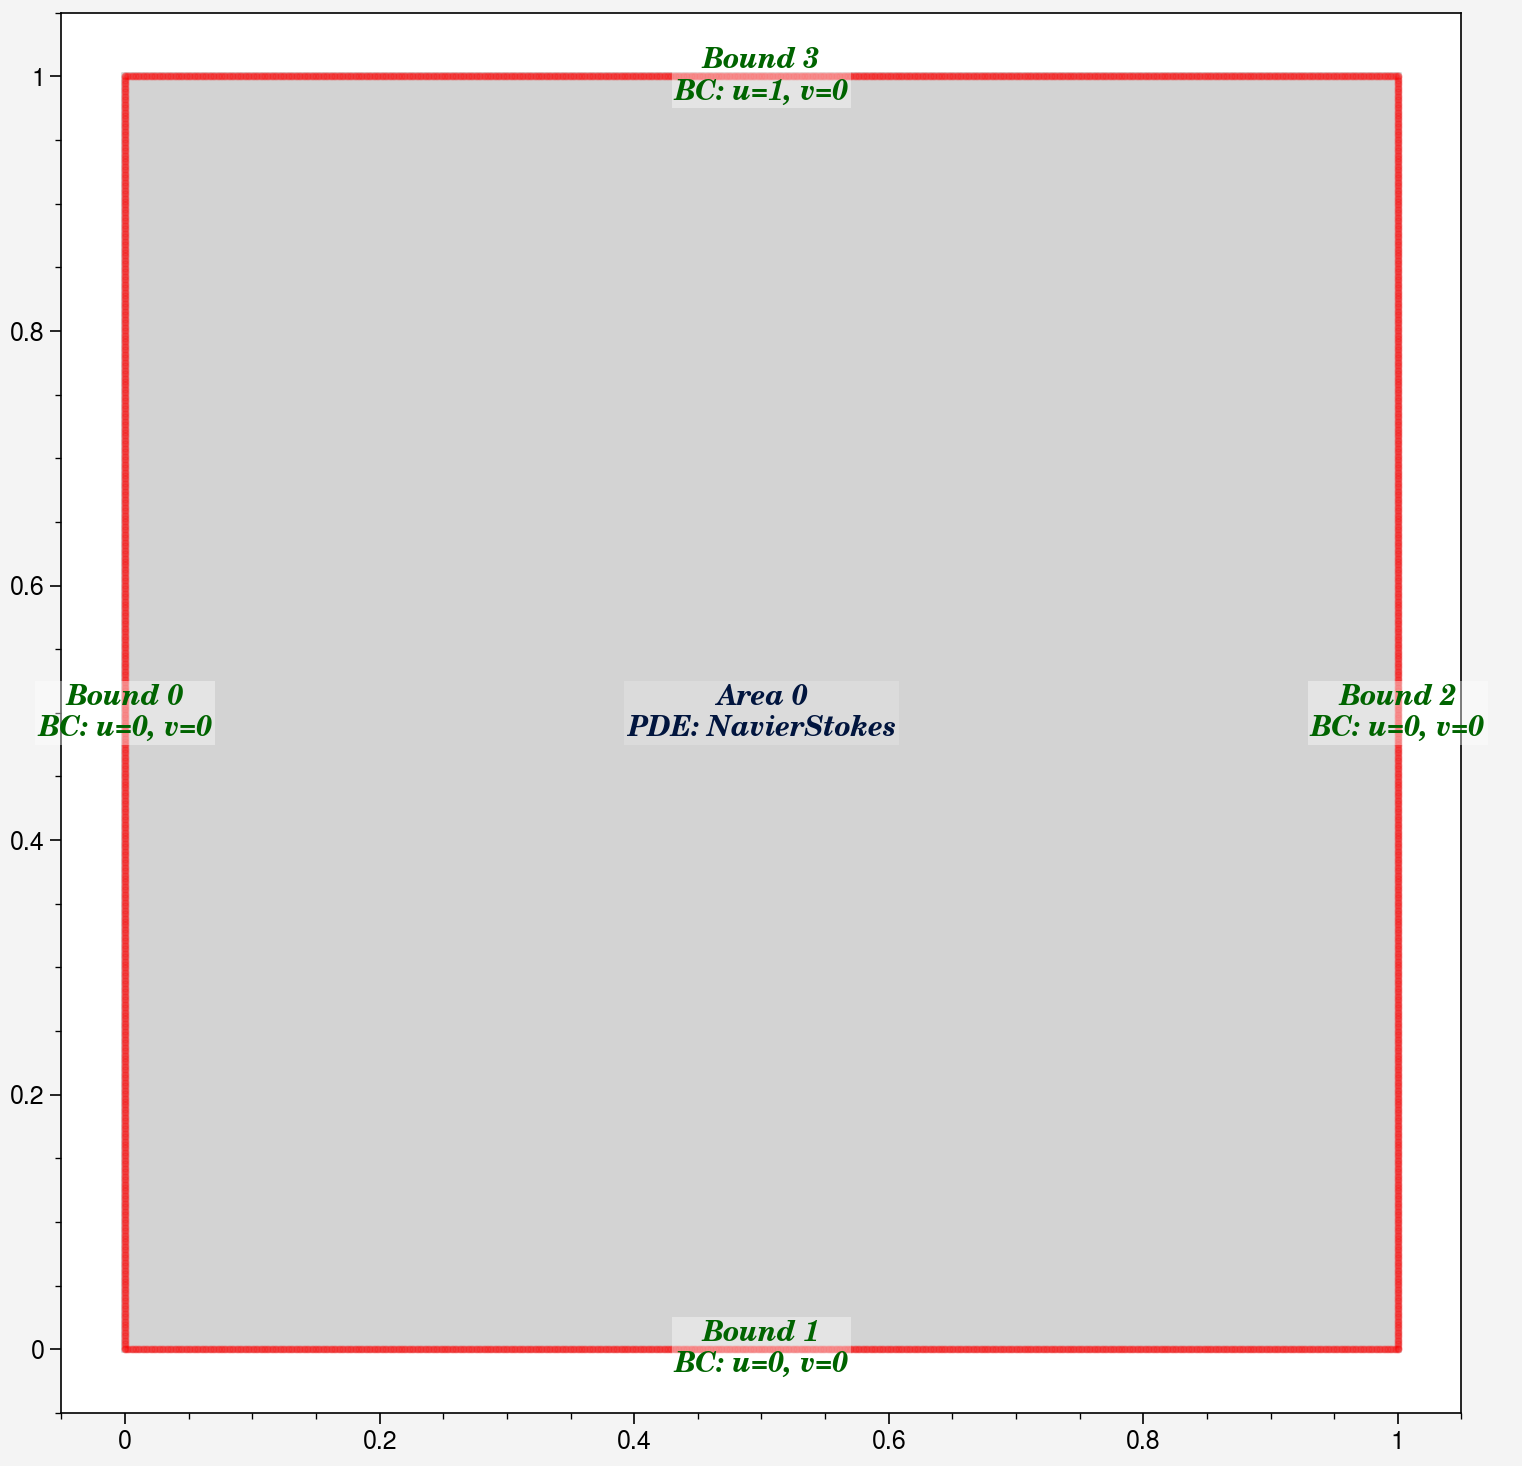

In [4]:
domain.bound_list[0].define_bc({'u': 0,'v': 0})
domain.bound_list[1].define_bc({'u': 0,'v': 0})
domain.bound_list[2].define_bc({'u': 0,'v': 0})
domain.bound_list[3].define_bc({'u': 1, 'v': 0})
domain.area_list[0].define_pde(df.NavierStokes(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup()


Sample initial points for training.

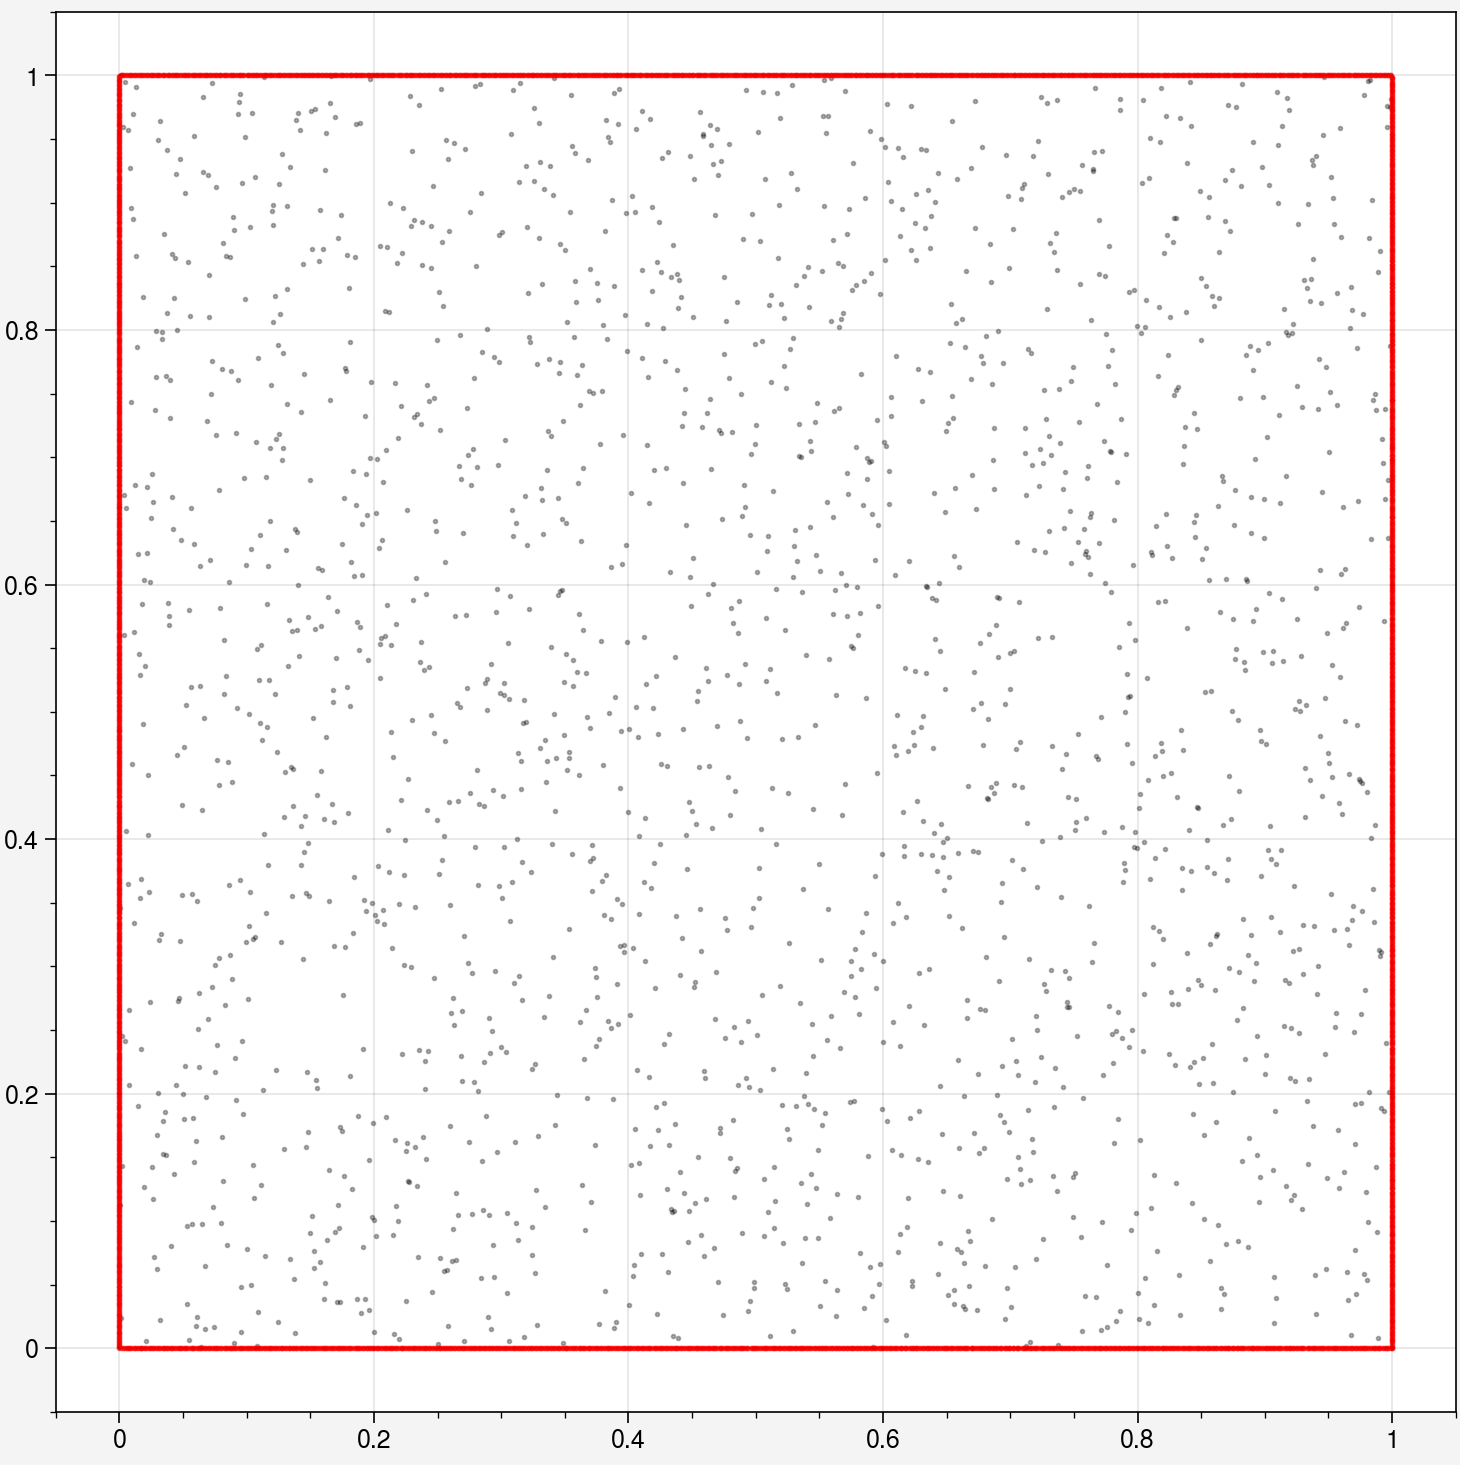

In [5]:
domain.sampling_lhs(bound_sampling_res=[1000, 1000, 1000, 1000], area_sampling_res=[2000])
domain.show_coordinates(display_physics=False)

## 3. Train the PINN model

Define how collocation points are sampled during training.

In [6]:
def do_in_adam(epoch, model):
    return
        
def do_in_lbfgs(epoch, model):
    if epoch % 100 == 0 and epoch > 0:
        domain.sampling_R3(bound_sampling_res=[1000, 1000, 1000, 1000], area_sampling_res=[2000])
        print(domain)

Train the model using Adam for initial training (faster convergence).

In [ ]:
model0 = df.PINN(width=50, length=5, input_vars=['x','y'], output_vars=['u','v','p'])

# Train the model
model1, model1best = model0.train_adam(
    learning_rate=0.004,
    epochs=2000,
    calc_loss=df.calc_loss_simple(domain),
    threshold_loss=0.05,
    do_between_epochs=do_in_adam)

Epoch: 1, total_loss: 1.24918, bc_loss: 1.24865, pde_loss: 0.00053
Epoch: 200, total_loss: 0.07081, bc_loss: 0.05901, pde_loss: 0.01181
Epoch: 400, total_loss: 0.06181, bc_loss: 0.05425, pde_loss: 0.00757
Epoch: 600, total_loss: 0.05923, bc_loss: 0.05093, pde_loss: 0.00830
Epoch: 800, total_loss: 0.05247, bc_loss: 0.04450, pde_loss: 0.00797
Stop: Loss 0.04949 < Threshold 0.05


Refine the model using LBFGS for higher precision.

In [8]:
# Train the model
model2 = model1best.train_lbfgs(
    calc_loss=df.calc_loss_simple(domain),
    epochs=450,
    threshold_loss=0.0005,
    do_between_epochs=do_in_lbfgs)

Epoch: 815, total_loss: 0.04800, bc_loss: 0.04119, pde_loss: 0.00681
Epoch: 865, total_loss: 0.00527, bc_loss: 0.00365, pde_loss: 0.00162
Epoch: 915, total_loss: 0.00311, bc_loss: 0.00231, pde_loss: 0.00080
number of bound : ['0: 1232', '1: 1412', '2: 1323', '3: 1177']
number of area : ['0: 2684']
Epoch: 965, total_loss: 0.00186, bc_loss: 0.00129, pde_loss: 0.00058
Epoch: 1015, total_loss: 0.00091, bc_loss: 0.00059, pde_loss: 0.00031
number of bound : ['0: 1575', '1: 1930', '2: 1523', '3: 1472']
number of area : ['0: 3386']
Epoch: 1065, total_loss: 0.00069, bc_loss: 0.00043, pde_loss: 0.00026
Training interrupted by user.


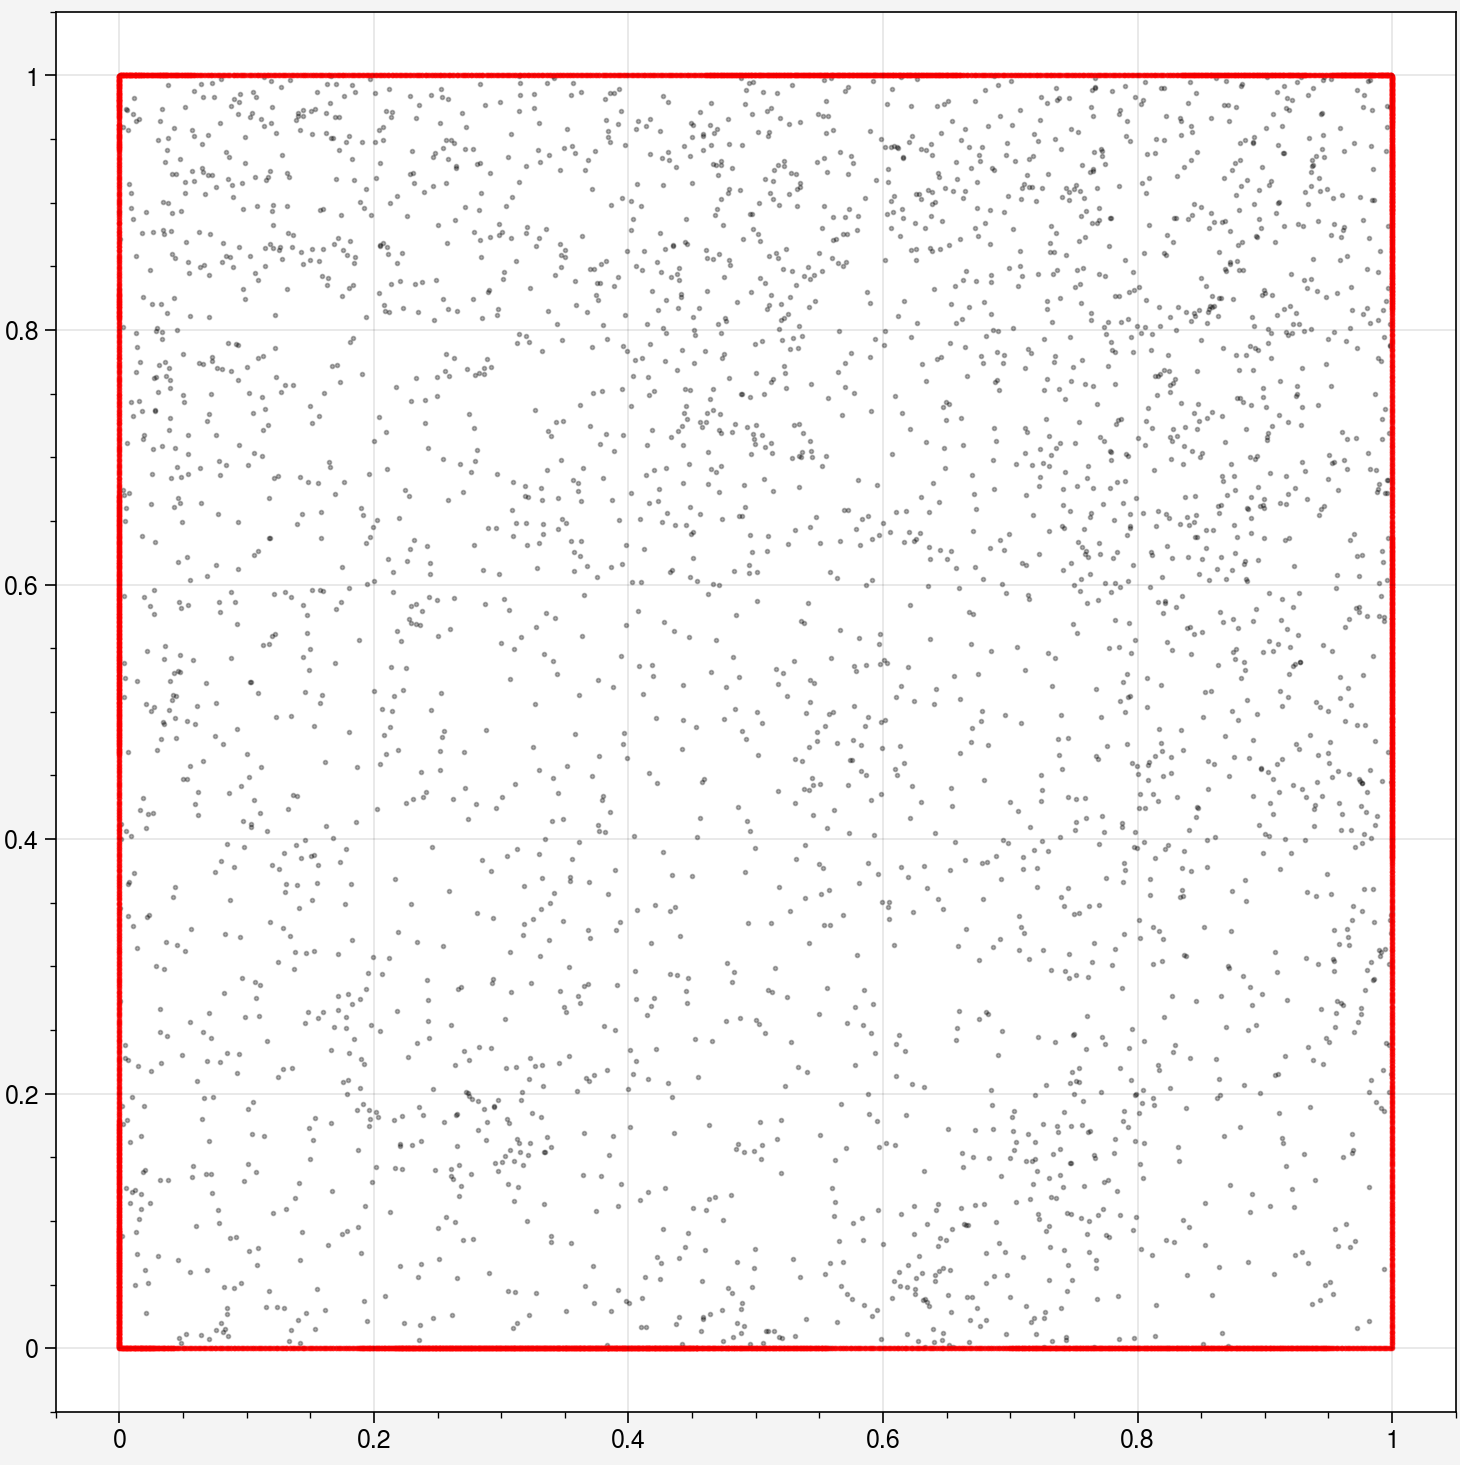

In [9]:
domain.show_coordinates()

Save or Load the model for later use

In [10]:
model2.save_as_pickle("model.pkl")
model2 = df.load_from_pickle("model.pkl")

## 4. Visualization

### 4.1 Visualize area

In [29]:
df.Visualizer.refwidth_default = 4

In [30]:
# Create object for evaluation
area_eval = domain.area_list[0].evaluate(model2)
# Sampling uniform points
area_eval.sampling_area([200, 200])
# Show available data's key
print(area_eval)

Available data keys: ('u', 'v', 'p', 'pde_residual', 'x', 'y', 'u_x', 'u_y', 'v_x', 'v_y', 'p_x', 'p_y', 'continuity_residual', 'x_momentum_residual', 'y_momentum_residual', 'total_loss', 'bc_loss', 'pde_loss')


In [31]:
area_eval['v_mag'] = (area_eval['u']**2 + area_eval['v']**2)**0.5

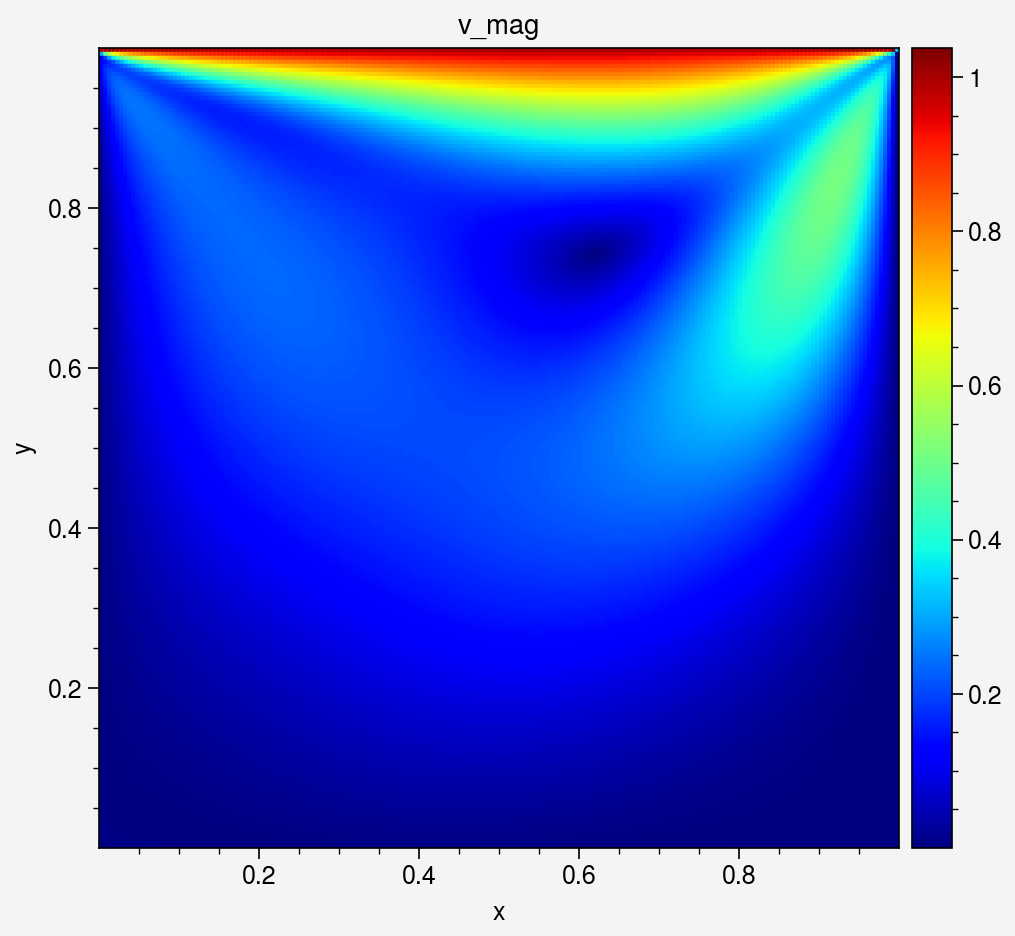

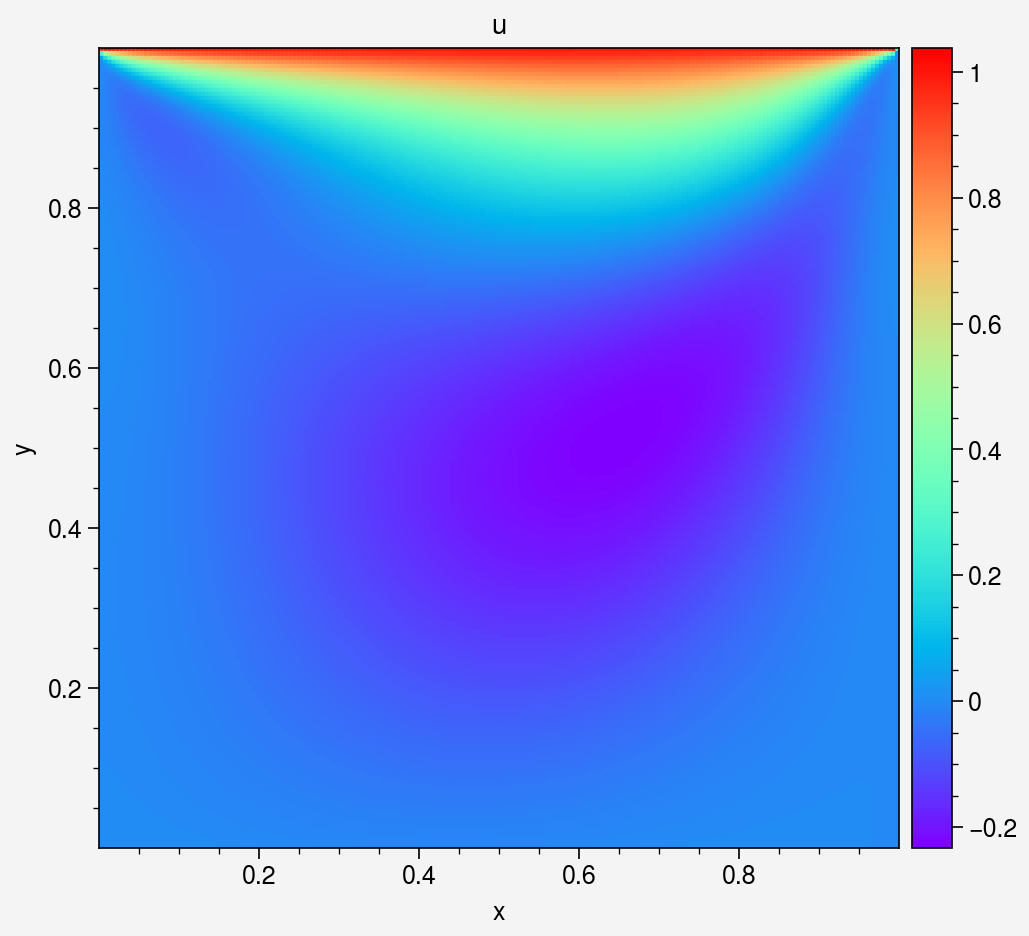

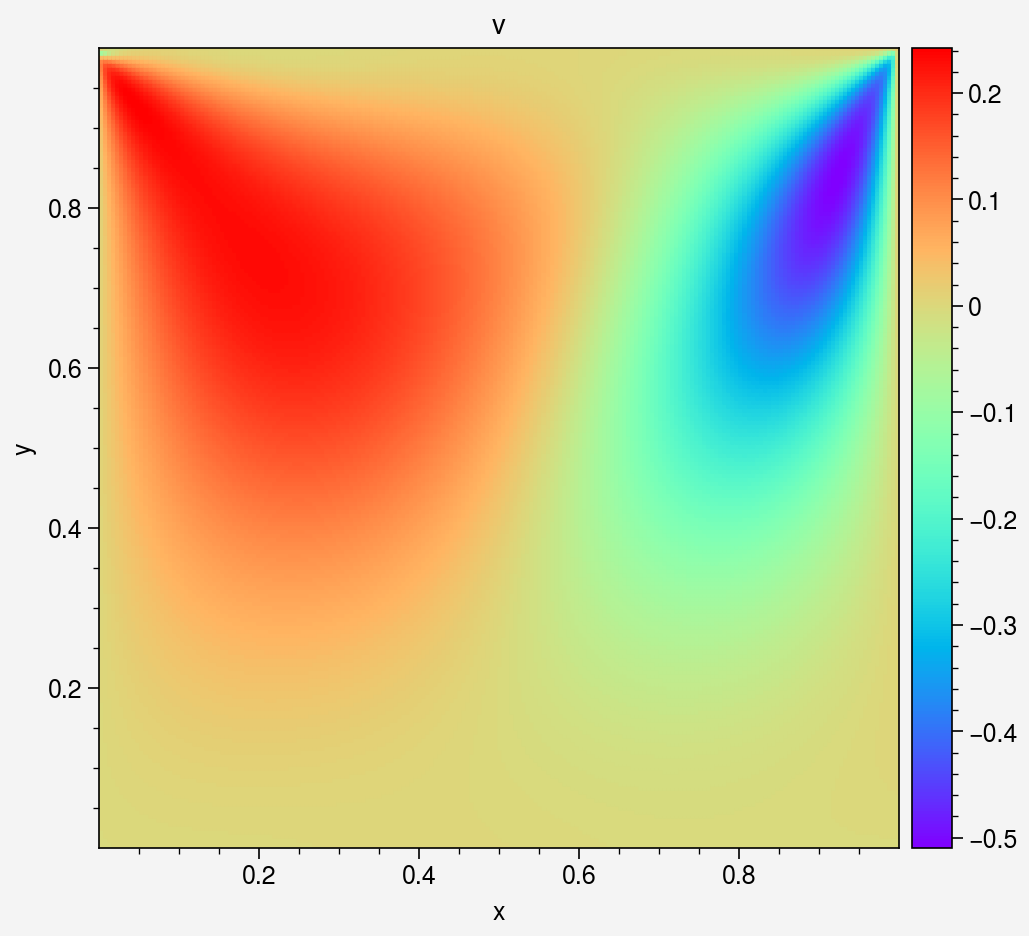

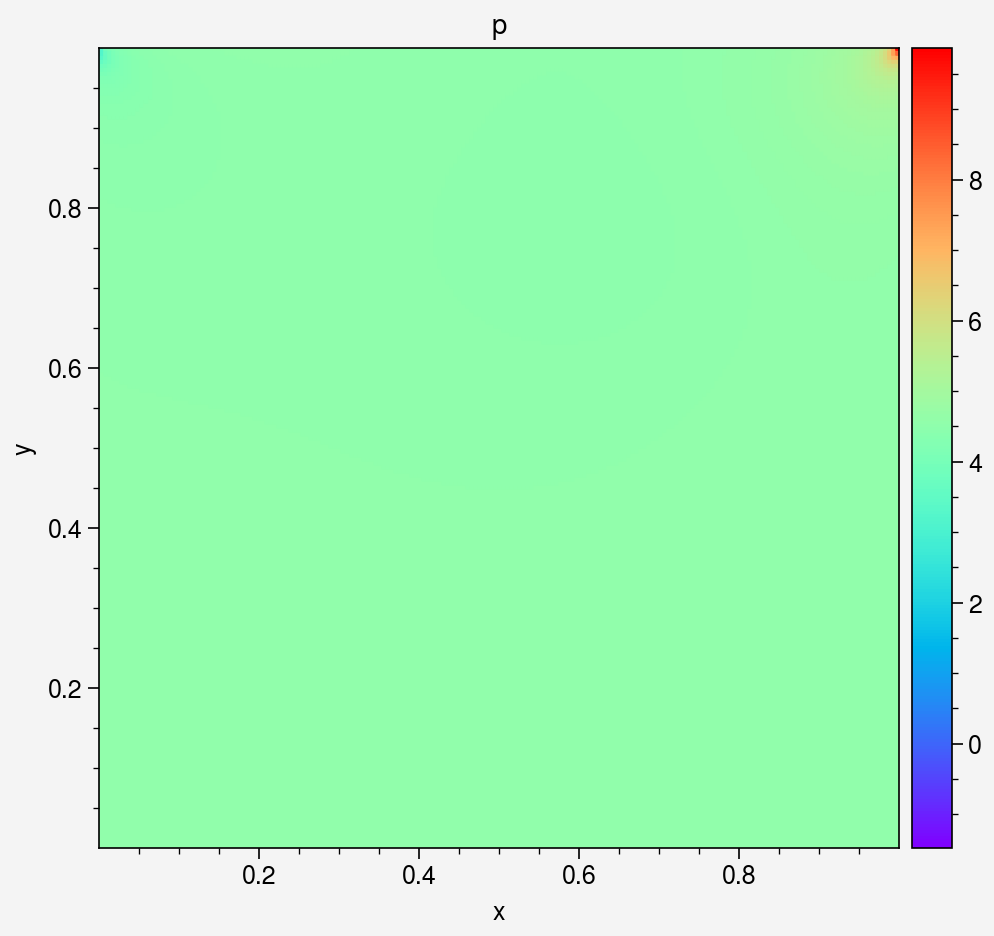

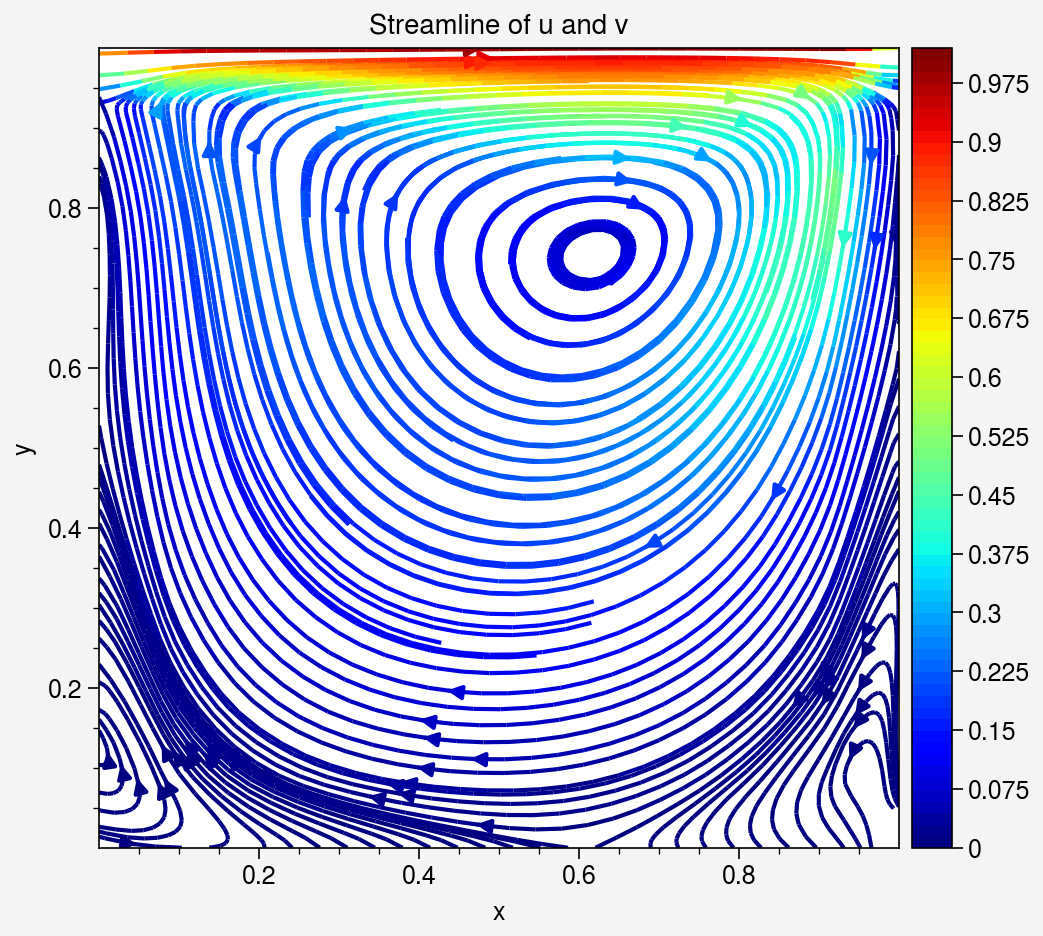

In [32]:
_ = area_eval.plot_color('v_mag', s=4, cmap='jet').savefig("colorplot_v_mag.png")
_ = area_eval.plot_color('u', s=4, cmap='rainbow')
_ = area_eval.plot_color('v', s=4, cmap='rainbow')
_ = area_eval.plot_color('p', s=4, cmap='rainbow')
_ = area_eval.plot_streamline('u', 'v', cmap = 'jet')

## 4.2 Visualize Neural Network data

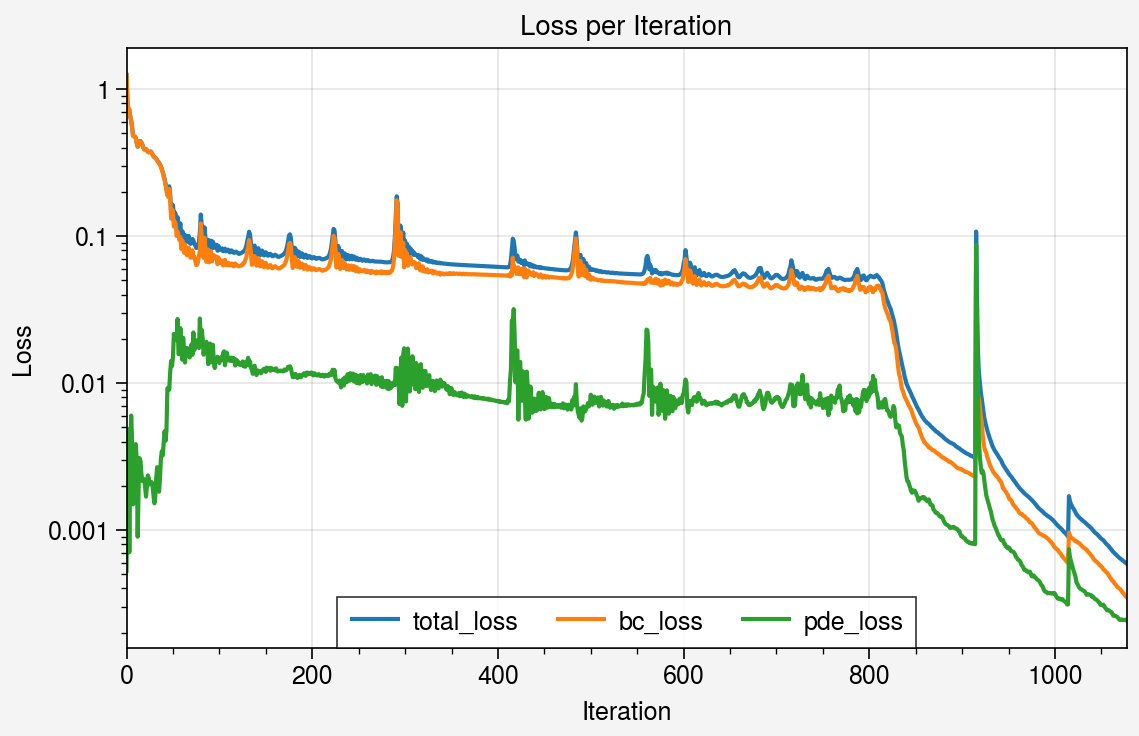

In [33]:
_ = area_eval.plot_loss_curve(log_scale=True)

### 4.4 Export data

In [34]:
# store the x,y,velocity_magnitude data
x_data = area_eval.data_dict['x']
y_data = area_eval.data_dict['y']
u_data = area_eval.data_dict['u']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, u_data))
np.savetxt('outlet_velocity.txt', array)